In [113]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import cv2

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alexteboul/english-premier-league-logo-detection-20k-images")

print("Path to dataset files:", path)
os.listdir(path)

Path to dataset files: C:\Users\PC\.cache\kagglehub\datasets\alexteboul\english-premier-league-logo-detection-20k-images\versions\4


['epl-logos-big', 'train.csv']

In [5]:
BASE_PATH = os.path.join(path,"epl-logos-big","epl-logos-big")

In [7]:
class_names = os.listdir(BASE_PATH)
print(class_names)

['arsenal', 'aston-villa', 'brentford', 'brighton', 'burnley', 'chelsea', 'crystal-palace', 'everton', 'leeds', 'leicester-city', 'liverpool', 'manchester-city', 'manchester-united', 'newcastle', 'norwich', 'southampton', 'tottenham', 'watford', 'west-ham', 'wolves']


In [8]:
class_nums = len(class_names)

In [16]:
def split_data(path):
    import splitfolders
    splitfolders.ratio(BASE_PATH,"Data",ratio=(0.8,0.1,0.1),seed=42)

In [17]:
split_data(BASE_PATH)

Copying files: 0 files [00:36, ? files/s]
Copying files: 20000 files [00:11, 1789.36 files/s]


In [18]:
TRAIN_PATH = "Data/train"
VAL_PATH = "Data/val"
TEST_PATH = "Data/test"

In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [26]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Görüntü boyutunu ayarla
    transforms.ToTensor(),  # Tensor formatına çevir
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizasyon
])

In [31]:
from random import shuffle


train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.ImageFolder(root=VAL_PATH,transform=transform)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

test_dataset = datasets.ImageFolder(root=TEST_PATH,transform=transform)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


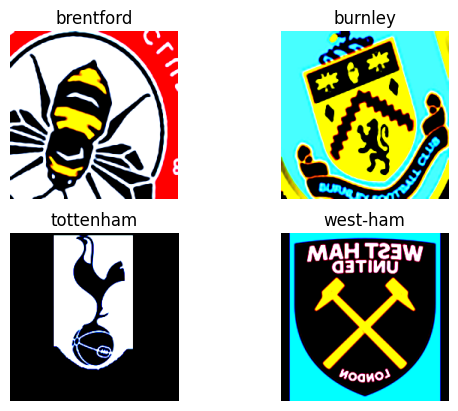

In [50]:
import matplotlib.pyplot as plt

for i, (images, labels) in enumerate(train_loader):
    if i == 4: 
        break
    plt.subplot(2,2,i+1)
    img = images[0].cpu().permute(1,2,0).numpy() 
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{class_names[labels[0].item()]}")
plt.show()


In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AINet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
    
        self.fc1 = nn.Linear(64 * 54 * 54, 100)
        self.fc2 = nn.Linear(100, 20)  
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  
        return x

In [84]:
conv_model = AINet()
device = "cuda" if torch.cuda.is_available() else "cpu"
conv_model.to(device)

AINet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=186624, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
)

In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_model.parameters(),lr=0.001)

import matplotlib.pyplot as plt
from tqdm import tqdm

history = {"train_loss": [], "val_loss": [], "val_acc": []}

def train_validate_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        epoch_loss = train_loss / len(train_loader)
        history["train_loss"].append(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}")

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        val_epoch_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_accuracy)

        print(f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

In [86]:
train_validate_model(conv_model, train_loader, val_loader, criterion, optimizer, epochs=10)

100%|██████████| 500/500 [00:50<00:00,  9.99it/s]


Epoch 1/10, Train Loss: 0.2718


100%|██████████| 63/63 [00:05<00:00, 12.06it/s]


Val Loss: 0.0296, Val Accuracy: 0.9915


100%|██████████| 500/500 [00:44<00:00, 11.33it/s]


Epoch 2/10, Train Loss: 0.0187


100%|██████████| 63/63 [00:04<00:00, 15.06it/s]


Val Loss: 0.0094, Val Accuracy: 0.9980


100%|██████████| 500/500 [00:44<00:00, 11.32it/s]


Epoch 3/10, Train Loss: 0.0002


100%|██████████| 63/63 [00:04<00:00, 14.97it/s]


Val Loss: 0.0051, Val Accuracy: 0.9995


100%|██████████| 500/500 [00:43<00:00, 11.41it/s]


Epoch 4/10, Train Loss: 0.0000


100%|██████████| 63/63 [00:04<00:00, 14.86it/s]


Val Loss: 0.0055, Val Accuracy: 0.9995


100%|██████████| 500/500 [00:44<00:00, 11.35it/s]


Epoch 5/10, Train Loss: 0.0000


100%|██████████| 63/63 [00:04<00:00, 14.81it/s]


Val Loss: 0.0052, Val Accuracy: 0.9995


100%|██████████| 500/500 [00:44<00:00, 11.21it/s]


Epoch 6/10, Train Loss: 0.0000


100%|██████████| 63/63 [00:04<00:00, 14.81it/s]


Val Loss: 0.0053, Val Accuracy: 0.9995


100%|██████████| 500/500 [00:44<00:00, 11.29it/s]


Epoch 7/10, Train Loss: 0.0000


100%|██████████| 63/63 [00:04<00:00, 15.04it/s]


Val Loss: 0.0054, Val Accuracy: 0.9995


100%|██████████| 500/500 [00:44<00:00, 11.26it/s]


Epoch 8/10, Train Loss: 0.0000


100%|██████████| 63/63 [00:04<00:00, 14.91it/s]


Val Loss: 0.0055, Val Accuracy: 0.9995


100%|██████████| 500/500 [00:44<00:00, 11.11it/s]


Epoch 9/10, Train Loss: 0.0000


100%|██████████| 63/63 [00:04<00:00, 13.77it/s]


Val Loss: 0.0056, Val Accuracy: 0.9995


100%|██████████| 500/500 [00:45<00:00, 11.05it/s]


Epoch 10/10, Train Loss: 0.0000


100%|██████████| 63/63 [00:04<00:00, 14.22it/s]

Val Loss: 0.0058, Val Accuracy: 0.9995


In [89]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Graph")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Graph")
    plt.legend()
    plt.grid()

    plt.show()

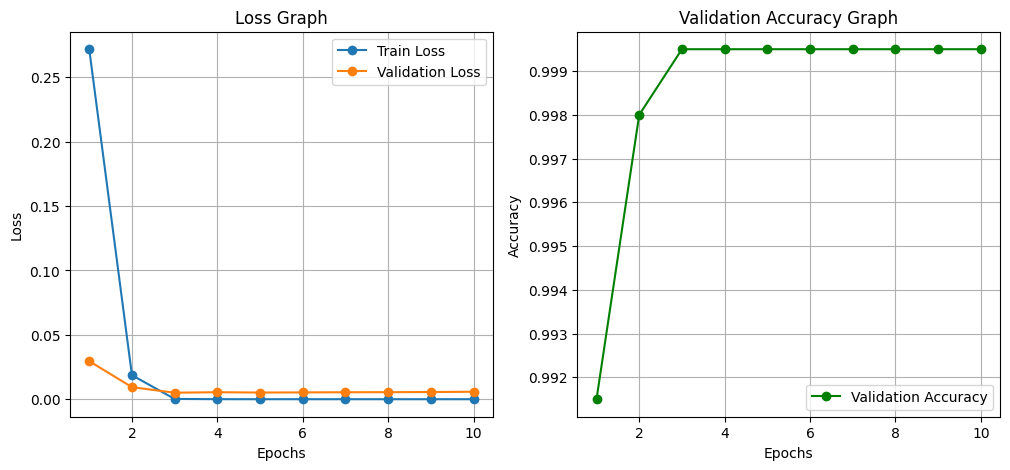

In [90]:
plot_history(history)

In [96]:


pred = []
true = []
conv_model.eval()
with torch.no_grad():
    test_loss = 0.0
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = conv_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        pred.extend(predicted.cpu().numpy())
        true.extend(labels.cpu().numpy())
pred = np.array(pred)
true = np.array(true)


100%|██████████| 63/63 [00:04<00:00, 14.39it/s]


In [97]:
print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Test Loss: 0.0011


In [119]:
def predict_images(image_paths: list):
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        img = transform(img).unsqueeze(0).to(device)
        output = conv_model(img)
        _, predicted = torch.max(output.data, 1)
        print(f"Predicted: {class_names[predicted.item()]}")

In [120]:
image_paths = ["arsenal_images.png","Manchester_City.png","liverpool.png","Manchester_United_Football_Club_Flag.png"]
predict_images(image_paths)

Predicted: arsenal
Predicted: manchester-city
Predicted: liverpool
Predicted: manchester-united
